In [1]:
import torch

import os

import numpy as np
import statistics

import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torchvision import transforms

from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.utils.data import ConcatDataset, DataLoader
import random

In [2]:
from preprocess import preprocess

In the final attempt, the performance of the custom model was improved by using an augmented dataset.

The architecture remained similar to the one presented in Notebook 2, with one modification: an additional convolutional layer was added. In the second notebook, this layer was removed during testing. And now with the  augmented dataset, it was tested in a full model configuration.

### Preprocessing

In [3]:
dataset = torch.load("dataset.pth", weights_only=False)

In [4]:
weights = torch.load("weights.pth")

In [5]:
trainloader,testloader,valloader = preprocess(dataset, 64)

Train dataset was augmented - each image was modified with 2 additional copies: one flipped horizontally, and another one with a random brightness shift. The images from train data loader were modified and combined into augmented dataset. Only training data was modified so the results on training and validation wouldn’t be affected with additional yet similar samples.

In [6]:
images = []
labels = []

for img, lab in trainloader:
    images.append(img)
    labels.append(lab)

    images.append(torch.flip(img, dims=(2,)))
    labels.append(lab)

    images.append(torch.clamp(img * (1 + random.uniform(-0.3,0.3)), 0, 1) )
    labels.append(lab)


images_tensor = torch.cat(images, dim=0)
labels_tensor = torch.cat(labels, dim=0)

temp_dataset = torch.utils.data.TensorDataset(images_tensor, labels_tensor)

In [7]:
trainloader = torch.utils.data.DataLoader(temp_dataset, batch_size=64, shuffle=True)

In [8]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

In [9]:
def show_image(tensor_img):
    plt.imshow(tensor_img.squeeze(), cmap='gray')
    plt.show()

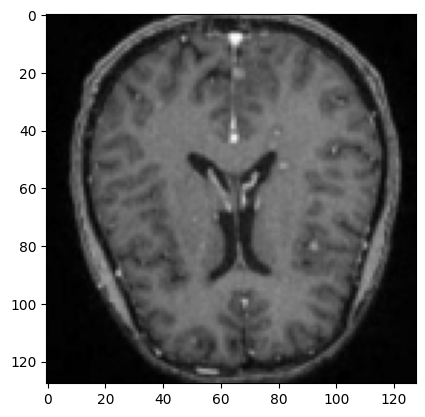

tensor(0)


In [10]:
sample_id = 40

show_image(images[sample_id])
print(labels[sample_id])

An additional convolutional layer was added to the network with an increased kernel size to capture more dataset-specific features

### Model

In [11]:
conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=2)
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(16, 64, 3)
conv3 = nn.Conv2d(64, 128, 7)
conv4 = nn.Conv2d(128, 256, 9)
fc1 = nn.Linear(256*2*2, 512)
fc3 = nn.Linear(512, 128)
fc4 = nn.Linear(128, 4)

x = images[sample_id].unsqueeze(0)
x = pool(F.relu(conv1(x)))
# # # x=F.relu(conv2(x))
x = pool(F.relu(conv2(x)))
x = pool(F.relu(conv3(x)))
x = pool(F.relu(conv4(x)))
# x = torch.flatten(x,1)
# # # x.shape
# x = F.relu(fc1(x))
# x = F.relu(fc3(x))
# x = fc4(x)
x.shape

torch.Size([1, 256, 2, 2])

In [12]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 =  nn.Conv2d(in_channels=1, out_channels=16, kernel_size=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 7)
        self.conv4 = nn.Conv2d(128, 256, 9)

        self.fc1 = nn.Linear(256*2*2, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

net = Net()

In [ ]:
device = torch.device(os.getenv("DEVICE"))
net.to(device)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(9, 9), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=4, bias=True)
)

Additionally, a scheduler was added to reduce the learning rate during training.

Since the SGD optimizer was used, the StepLR scheduler was selected to decrease the learning rate every 10 epochs

### Trainig

In [15]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR 

criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [16]:
train_loss_plot = []
test_loss_plot = []

In [17]:
best_result = np.inf
test_loss_array = []
n_epochs = 20
patience = 5

for epoch in range(n_epochs):
    net.train()

    total_loss = 0
    for X_batch, y_batch in trainloader:

        X_batch = X_batch.to(device,dtype=torch.float32)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        outputs = net(X_batch)

        loss = criterion(outputs.to(device), y_batch)
        train_loss_plot.append(loss.item())

        loss.backward()
        optimizer.step()

        total_loss += loss.item() 
    
    scheduler.step()

    net.eval()

    test_loss = 0
    with torch.no_grad():  
            
            for X_batch, y_batch in testloader:

                X_batch = X_batch.to(device,dtype=torch.float32)
                y_batch = y_batch.to(device)

                outputs = net(X_batch)
                t_loss = criterion(outputs.to(device), y_batch)
                test_loss_plot.append(t_loss.item())

                test_loss+=t_loss

    loss = total_loss / (len(trainloader))
    loss_test = test_loss / (len(testloader))

    test_loss_array.append(loss_test)

    if loss_test < best_result:
        torch.save(net.state_dict(), "./custom_net_aug1.pth")

    print(f"Epoch: {epoch}, Train loss: {loss}, Test loss: {loss_test}")

    if len(test_loss_array)>patience+1:
        if not (any(x > (test_loss_array[-1]+0.01) for x in test_loss_array[len(test_loss_array)-patience-1:-1])):
            break

Epoch: 0, Train loss: 1.2931855430728512, Test loss: 1.0880047082901
Epoch: 1, Train loss: 0.8612590350602802, Test loss: 0.6328555941581726
Epoch: 2, Train loss: 0.5841878263573898, Test loss: 0.4862920939922333
Epoch: 3, Train loss: 0.42846059626654576, Test loss: 0.34412673115730286
Epoch: 4, Train loss: 0.27185757066074173, Test loss: 0.286121129989624
Epoch: 5, Train loss: 0.18303488236116736, Test loss: 0.2843203842639923
Epoch: 6, Train loss: 0.11405483977378983, Test loss: 0.23139335215091705
Epoch: 7, Train loss: 0.08036332458355709, Test loss: 0.3118326961994171
Epoch: 8, Train loss: 0.07419410992787513, Test loss: 0.2436540275812149
Epoch: 9, Train loss: 0.04690548256529789, Test loss: 0.28367090225219727
Epoch: 10, Train loss: 0.015107494011202729, Test loss: 0.25568950176239014
Epoch: 11, Train loss: 0.004510719278876326, Test loss: 0.2710719108581543
Epoch: 12, Train loss: 0.0028602232606652635, Test loss: 0.28630784153938293
Epoch: 13, Train loss: 0.0020090562134627314, 

### Results

The loss was decreasing with an overfit at the end, however best results were saved and used for prediction.

<Axes: >

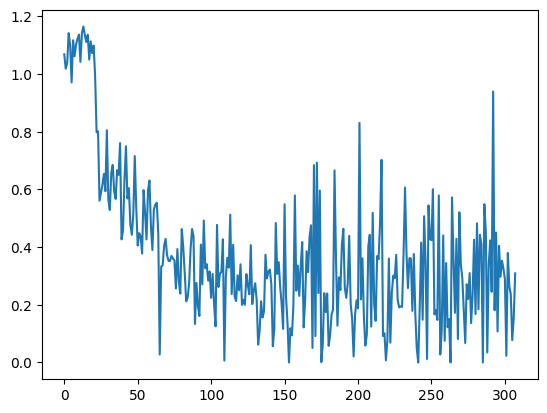

In [18]:
import seaborn as sns

sns.lineplot(data = test_loss_plot)

<Axes: >

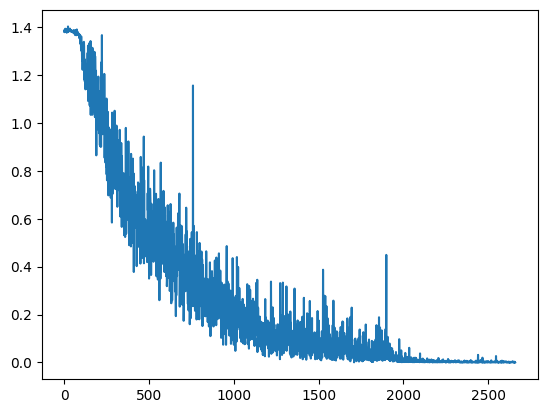

In [19]:
sns.lineplot(data = train_loss_plot)

In [24]:
net.load_state_dict(torch.load("custom_net_aug1.pth"))

<All keys matched successfully>

In [25]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [28]:
accuracy = []
f1_scr = []
precision = []
recall=[]

with torch.no_grad():
    
    for X_batch, y_batch in valloader:
        outputs_pred = net(X_batch.to(device))

        _, topi = outputs_pred.topk(1)

        topi=topi.cpu()

        acc = accuracy_score(y_batch,topi.squeeze(-1))
        f1 = f1_score(y_batch,topi.squeeze(-1), average="macro")
        pr = precision_score(y_batch,topi.squeeze(-1), average="macro")
        rec = recall_score(y_batch,topi.squeeze(-1),average="macro")


        accuracy.append(float(acc))
        f1_scr.append(float(f1))
        precision.append(float(pr))
        recall.append(float(rec))


The final prediction showed that the method worked well, as the validation accuracy on the augmented dataset exceeded 94%, with other statistics at a similar level. Data augmentation combined with learning rate adjustment enabled the highest results to be achieved - way higher than the ones achieved using other techniques

In [29]:
print(statistics.mean(accuracy))
print(statistics.mean(f1_scr))
print(statistics.mean(precision))
print(statistics.mean(recall))

0.9488636363636364
0.9462515021043831
0.948493173055966
0.9472894883714965
